# 2. Can we predict the price of a listing given its features?

100%|██████████| 100/100 [27:22<00:00, 16.43s/trial, best loss: -0.7977160192282038]
best: {'max_depth': 5.0, 'max_features': 230.0, 'n_estimators': 170.0}


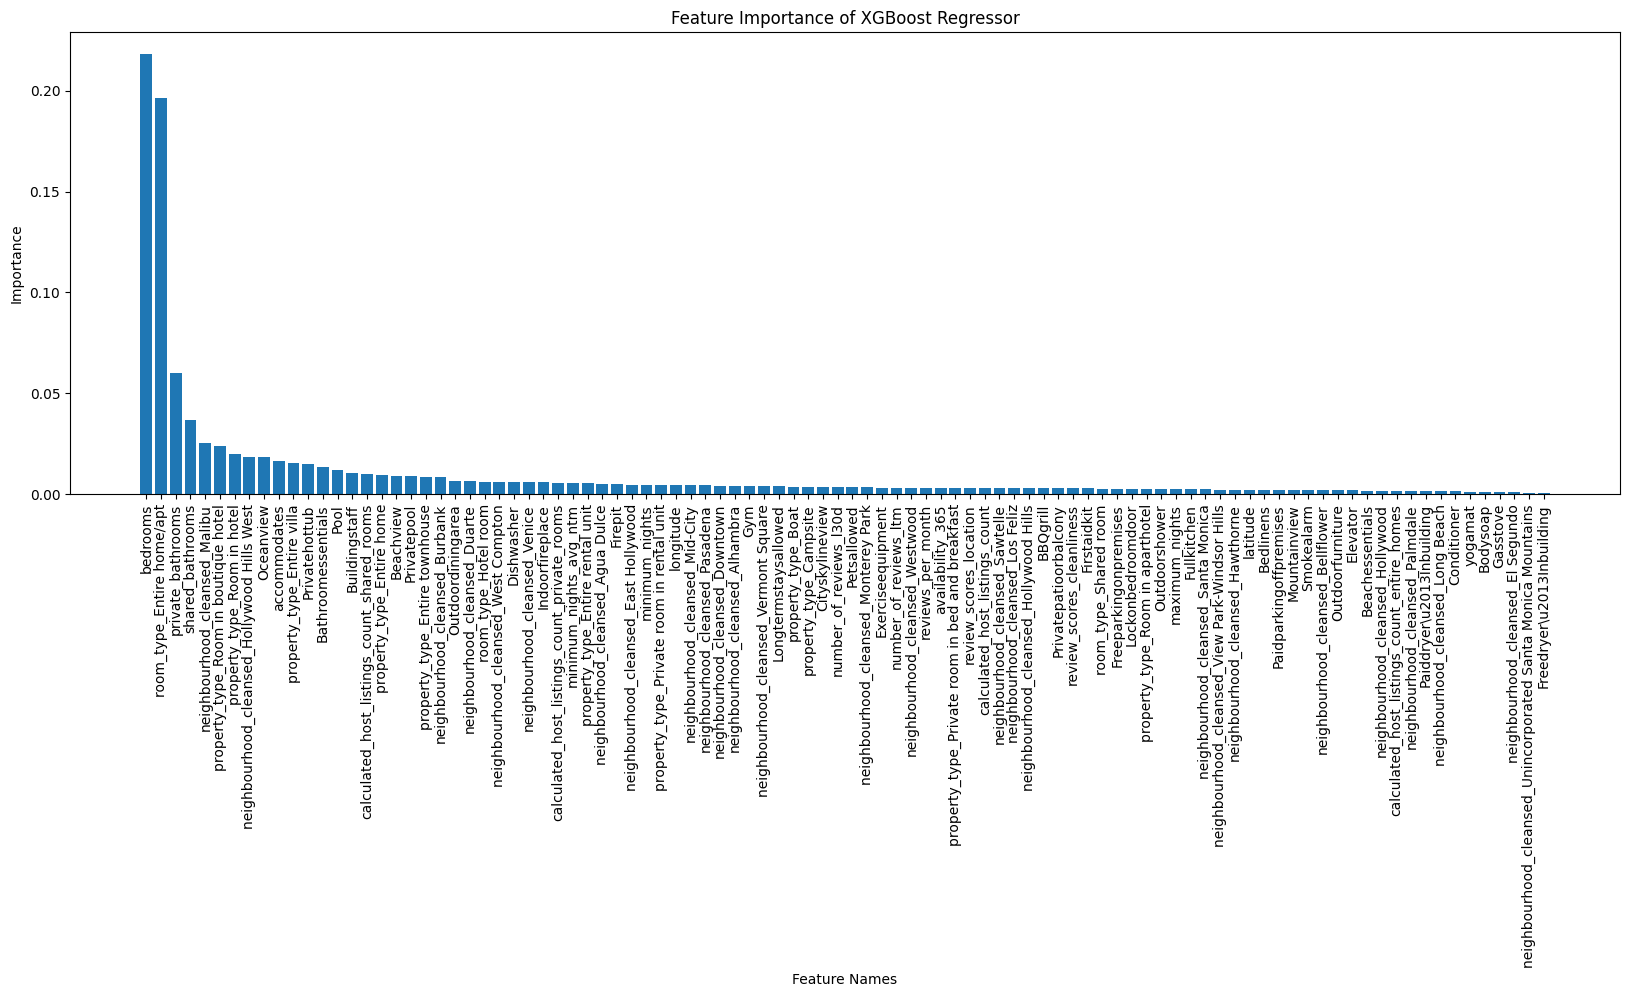

Mean squared error: 0.1696419737467711
Mean absolute error: 0.27206252527846236
Mean absolute error (original scale): 97.05695175168015
R2 score: 0.7776681472642398


['../../models/question_2/price_model.pkl']

In [3]:
# NOTES: DONE
import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.pipeline import Pipeline
import os 
import matplotlib.pyplot as plt
import joblib



def load_data(path):
    """
    Load data for regression for price prediction.

    Args:
        path (str): path to data.

    Returns:
        X (pd.DataFrame): feature data.
        y (np.array): target data.

    """
    if not os.path.isfile(path):
        raise FileNotFoundError(f'File not found at path: {path}')
    data = pd.read_csv(path, compression='gzip')
    # Drop unnecessary columns
    data.drop(columns=['host_since', 'last_review', 'first_review', 'id'], inplace=True)
    # Feature data
    X = data.drop(columns=['price'])
    # Target data
    # We apply log transformation to deal with problem related to price distribution (non linear relationship)
    y = np.log(data['price'])
    return X, y

def create_pipeline(params):
    """ 
    Create pipeline for modeling.

    Args:
        params (dict): dictionnary containing parameters (n_estimators, max_depth, max_features).

    Returns:
        pipeline (Pipeline): Pipeline object.
    Note:
    Check regression with xgb in https://machinelearningmastery.com/xgboost-for-regression/
    """
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']))
    pipeline = Pipeline([
        ('Feature scaler', StandardScaler()),
        ('Feature_Selection', SelectFromModel(model, max_features=int(params['max_features']))),
        ('Model_Regressor', model)
    ])
    return pipeline


def objective(params, X_train, y_train, X_val, y_val): 
    
    """ 
    Objective functions for hyperparameter optimization.
    ref: http://hyperopt.github.io/hyperopt/

    Args:
        params (dict): dictionnary containing parameters (n_estimators, max_depth, max_features).

    Returns:
        result (dict): dictionnary containing the loss and status.
    """
    pipeline = create_pipeline(params)
    pipeline.fit(X_train, y_train)
    r2 = evaluate_model(X_val, y_val, pipeline)
    result = {'loss': -r2, 'status': STATUS_OK}
    return result

def evaluate_model(X, y, model):
    """
    Evaluate the model.

    Args:
        X (np.array): feature data from validation/test sets.
        y (np.array): target data  from validation/test sets.
        model (xgb.XGBRegressor): model.

    Returns:
        r2 (float): r2 score.

    """
    y_prediction = model.predict(X)
    r2 = r2_score(y, y_prediction)
    return r2

def plot_feature_importance(feature_columns, feature_importances, model_name, report_dir):
    """
    Plot Feature importance of a tree model

    Args:
        feature_columns (list): List containing the selected feature names.
        feature_importances (array): Array containing feature importances.
        model_name (str): Name of the investigated model.
        report_dir (str): Path to save the artifact dir where to save the importance plots.

    Returns:
        None

    """

    # Create a dataframe containing the selected feature importances
    features_importances = pd.DataFrame({'feature': feature_columns, 'importance': feature_importances})
    features_importances = features_importances.sort_values(by='importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(20, 6))
    plt.bar(features_importances['feature'], features_importances['importance'])
    plt.xlabel('Feature Names')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance of {model_name}')
    plt.xticks(rotation='vertical')
    plt.savefig(f'{report_dir}/{model_name}_feature_importance.png', bbox_inches='tight')
    plt.show()

# Load the data
path = '../../data/processed/question_1/listings_preprocessed_onehot.csv.gz'
X, y = load_data(path)

# Split the data into training/validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Define the search space for hyperparameters
# We mainly look for the optimal number of features to select
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 13, 1),
    'max_features': hp.quniform('max_features', 10, 600, 10),
}

# Perform hyperparameter optimization using hyperopt (tpe is a bayesian optimization algorithm) to avoid long exhaustive search methods (GridSearch)
trials = Trials()
best = fmin(lambda params: objective(params, X_train, y_train, X_val, y_val), 
            space=space, 
            algo=tpe.suggest, 
            max_evals=100, 
            trials=trials)

print('best:', best)

# Create pipeline with best hyperparameters
best_model = create_pipeline(best)

# Fit the best model to the data
best_model.fit(X_train_val, y_train_val)

# Get feature importance from the regressor model
selected_feature_importances = best_model.named_steps['Model_Regressor'].feature_importances_

# Get the selected features
selected_features = best_model.named_steps['Feature_Selection'].get_support()
selected_feature_columns = X_train.columns[selected_features].tolist()

# plot the feature importance
model_name = 'XGBoost Regressor'
report_dir = '../../reports/figures/question_2/'
plot_feature_importance(selected_feature_columns, selected_feature_importances, model_name, report_dir)

# Print some evaluation metrics
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_original = mean_absolute_error(np.exp(y_test), np.exp(y_pred))

print('Mean squared error:', mse)
print('Mean absolute error:', mae)
print('Mean absolute error (original scale):', mae_original)
print('R2 score:', r2)

# save model sklearn pipeline
joblib.dump(best_model, '../../models/question_2/price_model.pkl')

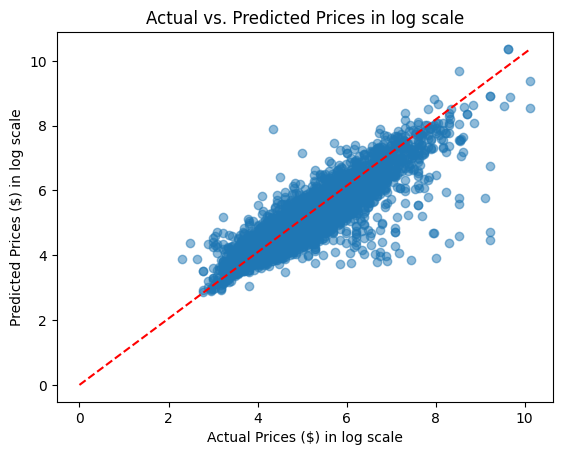

In [4]:
# Create a scatter plot of actual vs. predicted prices
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_pred)], 'r', linestyle='--')

plt.xlabel("Actual Prices ($) in log scale")
plt.ylabel("Predicted Prices ($) in log scale")
plt.title("Actual vs. Predicted Prices in log scale")
# save the plot
plt.savefig(f'{report_dir}/actual_vs_predicted_prices_log_scale.png', bbox_inches='tight')
plt.show()